In [1]:
# Modified from:
#   fast-DiT: https://github.com/chuanyangjin/fast-DiT/blob/main/extract_features.py
import os
os.environ['TORCH_COMPILE_DISABLE'] = '0'

import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_grad_enabled(False)

import torch.distributed as dist
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
from torchvision import transforms
import numpy as np
import argparse
import sys
sys.path.append('/root/kongly/AR/LlamaGen')
from utils.distributed import init_distributed_mode
from dataset.augmentation import center_crop_arr
from dataset.build import build_dataset
sys.path.append('/root/kongly/AR/LlamaGen/external_tokenizers/flextok')
from external_tokenizers.flextok.flextok.flextok_wrapper import FlexTokFromHub
from external_tokenizers.flextok.flextok.utils.misc import get_bf16_context
from tqdm import tqdm


/root/miniconda3/envs/TiTok3D/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dataset.imagenet import get_code_dataset

In [3]:
dataset = get_code_dataset(
    "/root/kongly/AR/LlamaGen/dataset/ImageNet-1k/flextok_codes/random_crop/h5_dataset"
)

In [4]:
loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=32)

In [8]:
for x, y, _ in loader:
    z_indices = x.reshape(x.shape[0], -1)
    c_indices = y.reshape(-1)
    assert z_indices.shape[0] == c_indices.shape[0]
    break

In [6]:
t[0].shape

torch.Size([1, 256])

In [14]:
min_val = 999999999
max_val = -999999999
from tqdm import tqdm
for t in tqdm(loader):
    min_val = min(min_val, t[0].min())
    max_val = max(max_val, t[0].max())

100%|██████████| 128117/128117 [02:49<00:00, 755.89it/s]


In [18]:
min_val

tensor(-32768, dtype=torch.int16)

In [19]:
max_val

tensor(32767, dtype=torch.int16)

In [23]:
max_val.to(torch.int32) - min_val.to(torch.int32) + 1

tensor(65536, dtype=torch.int32)

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--data-path", type=str, default='/root/kongly/AR/LlamaGen/dataset/ImageNet-1k/data/train')
parser.add_argument("--code-path", type=str, default='/root/kongly/AR/LlamaGen/dataset/ImageNet-1k/flextok_codes')
parser.add_argument("--dataset", type=str, default='imagenet')
parser.add_argument("--image-size", type=int, choices=[256, 384, 448, 512], default=256)
parser.add_argument("--crop-range", type=float, default=1.1, help="expanding range of center crop")
parser.add_argument("--num-workers", type=int, default=24)
parser.add_argument("--global-seed", type=int, default=42)
parser.add_argument("--single", action='store_true')
args = parser.parse_args([])

In [3]:
rank = 0
device = 'cuda'
seed = args.global_seed * 8 + rank
torch.manual_seed(seed)
print(f"Starting rank={rank}, seed={seed}, world_size={8}.")

# create and load model
vq_model = FlexTokFromHub.from_pretrained('/root/kongly/ckpts/flextok_d12_d12_in1k/')
vq_model.to(device)
vq_model.eval()

Starting rank=0, seed=336, world_size=8.
Loading weights from local directory


FlexTokFromHub(
  (vae): StableDiffusionVAE(
    (vae): AutoencoderKL(
      (encoder): Encoder(
        (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (down_blocks): ModuleList(
          (0): DownEncoderBlock2D(
            (resnets): ModuleList(
              (0-1): 2 x ResnetBlock2D(
                (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
                (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (nonlinearity): SiLU()
              )
            )
            (downsamplers): ModuleList(
              (0): Downsample2D(
                (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
              )
            )
          )
          (1): DownEncoderBlock2D(

In [6]:
import numpy as np
d = np.load(
    "/root/kongly/AR/LlamaGen/dataset/ImageNet-1k/flextok_codes/random_crop/imagenet256_codes/0_0.npy"
)
d.shape

(1, 10, 256)

In [9]:
from flextok.utils.misc import detect_bf16_support, get_bf16_context, get_generator

with get_bf16_context(True):
    reconst = vq_model.detokenize(
        [torch.Tensor(d).reshape(10, 256)[0].unsqueeze(0).to(device)],
        timesteps=50,  # Number of denoising steps
        guidance_scale=2,  # Classifier-free guidance scale
        perform_norm_guidance=True,  # APG, see https://arxiv.org/abs/2410.02416
        # Optionally control initial noise. Note that while the initial noise is deterministic, the rest of the model isn't.
        generator=get_generator(seed=0, device=device),
        verbose=True,  # Enable to show denoising progress bar with tqdm
    )

100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


In [33]:
from flextok.utils.misc import detect_bf16_support, get_bf16_context, get_generator
with get_bf16_context(True):
    reconst = vq_model.detokenize(
        [t[0].to('cuda')],
        timesteps=50,  # Number of denoising steps
        guidance_scale=2,  # Classifier-free guidance scale
        perform_norm_guidance=True,  # APG, see https://arxiv.org/abs/2410.02416
        # Optionally control initial noise. Note that while the initial noise is deterministic, the rest of the model isn't.
        generator=get_generator(seed=0, device=device),
        verbose=True,  # Enable to show denoising progress bar with tqdm
    )

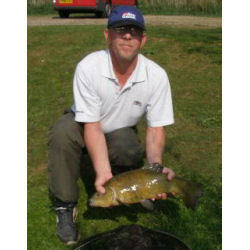

In [34]:
from PIL import Image
Image.open(t[2][0])

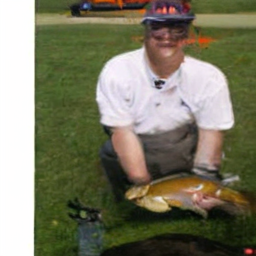

In [10]:
from flextok.utils.demo import imgs_from_urls, denormalize, batch_to_pil
batch_to_pil(reconst)

In [4]:
# Setup data:
crop_size = int(args.image_size * args.crop_range)
transform = transforms.Compose([
    transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, crop_size)),
    transforms.TenCrop(args.image_size), # this is a tuple of PIL Images
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # returns a 4D tensor
])

print("Constructing dataset...")
dataset = build_dataset(args, transform=transform)

Constructing dataset...


In [5]:
sampler = DistributedSampler(
    dataset,
    num_replicas=8,
    rank=rank,
    shuffle=False,
    seed=args.global_seed
)
loader = DataLoader(
    dataset,
    batch_size=1, # important!
    shuffle=False,
    sampler=sampler,
    num_workers=32,
    pin_memory=True,
    drop_last=False
)

# Initialize progress bar for rank 0 or single process
progress_bar = tqdm(loader, desc="Processing", disable=(not args.single and rank != 0))



Processing:   0%|          | 0/160146 [00:00<?, ?it/s]

In [6]:
total = 0
x_concat = []
y_concat = []
index = 0
start_idx = 0
for x, y in progress_bar:
    if index > start_idx:
        x = x.to(device)
        x_all = x.flatten(0, 1)
        y = y.to(device)

        with get_bf16_context(True):
            tokens_list = vq_model.tokenize(x_all)
        
        codes = torch.cat(tokens_list, dim=0)

        x = codes.detach().cpu().numpy()
        x_concat.append(x)
    if total % 50 == 0:
        if index > start_idx:
            # np.save(f'{args.code_path}/{args.dataset}{args.image_size}_codes/{rank}_{index}.npy', np.array(x_concat))
            pass
        x_concat = []
    
    if index > start_idx:
        y = y.detach().cpu().numpy()    # (1,)
        y_concat.append(y)
    if total % 50 == 0:
        if index > start_idx:
            # np.save(f'{args.code_path}/{args.dataset}{args.image_size}_labels/{rank}_{index}.npy', np.array(y_concat))
            pass
        y_concat = []
        index += 1
    
    total += 1

Processing:   0%|          | 28/160146 [00:20<32:39:14,  1.36it/s]


KeyboardInterrupt: 